# Defects correction algorithm using point cloud data

## Introduction
This program is the testing playground for developing the defect correction algorithm.
Things to explore here:
- Basic point cloud visualization by python
- Point cloud segmentation 
- Contour extraction by DBSCAN clustering
- Different method for polygon infill tool path generation
- Zig-zag path generation

## Set up

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import pandas as pd
import open3d as o3d
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
# %matplotlib auto
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 1. Point cloud processing by Open3D library

#### step one, obtain, convert the point cloud data into desired format
The accepted format for open3d library are ply, pcd, txt, ect. 
The best practice is using the __pcd__ file format as default, as the it is consistent with other program.

### File IO by open3d

In [2]:
## File IO
print("Testing IO for point cloud ...")

##--------------read point cloud data, save to open3d object--------------
pcd = o3d.io.read_point_cloud(os.path.join(DATA_PATH, "Point_cloud.pcd"))
# pcd = o3d.io.read_point_cloud(os.path.join(DATA_PATH, "Y1_seg.pcd"))
print(pcd)

## write the point cloud into a pcd file
# o3d.io.write_point_cloud(os.path.join(DATA_PATH, "copy_of_points.pcd"), pcd)

Testing IO for point cloud ...
geometry::PointCloud with 98371 points.


### Point cloud visualizaiton by open3d

In [3]:
# normal visualization, this will prompt a window
o3d.visualization.draw_geometries([pcd]) 

# for advanced visualization from jupyter lab
from open3d import JVisualizer

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

### voxel grid downsampling

In [4]:
print("Downsample the point cloud with a voxel of 0.5")
downsample_pcd = pcd.voxel_down_sample(voxel_size=0.5)

o3d.visualization.draw_geometries([downsample_pcd])

Downsample the point cloud with a voxel of 0.5


## 2. Point cloud visualizaiton by matplotlib

In [5]:
# ---- using numpy to print all the points -------
points_np_array = np.asarray(pcd.points)
print("the points are: \n")
print(points_np_array)
#------extract x,y,z value of the points-----
x = points_np_array[:,0]
y = points_np_array[:,1]
z = points_np_array[:,2]
print("the z value extracted: \n" )
print (z)

# --------mean height-------------------
z_mean = np.mean(z)
z_mean = z_mean + 0.17
print("Z mean: " + str(z_mean))

the points are: 

[[ -10.13915588  -19.27032314 -226.7965633 ]
 [ -10.13968095  -19.19431511 -226.762755  ]
 [ -10.14048379  -19.1195331  -226.7369091 ]
 ...
 [  10.17310155   19.43268697 -227.109935  ]
 [  10.17420343   19.51052893 -227.1563463 ]
 [  10.17346534   19.58841296 -227.1986699 ]]
the z value extracted: 

[-226.7965633 -226.762755  -226.7369091 ... -227.109935  -227.1563463
 -227.1986699]
Z mean: -225.9864015660957


## Calculate the plane for segmentation

Text(0.5, 0.92, '2D reference plane')

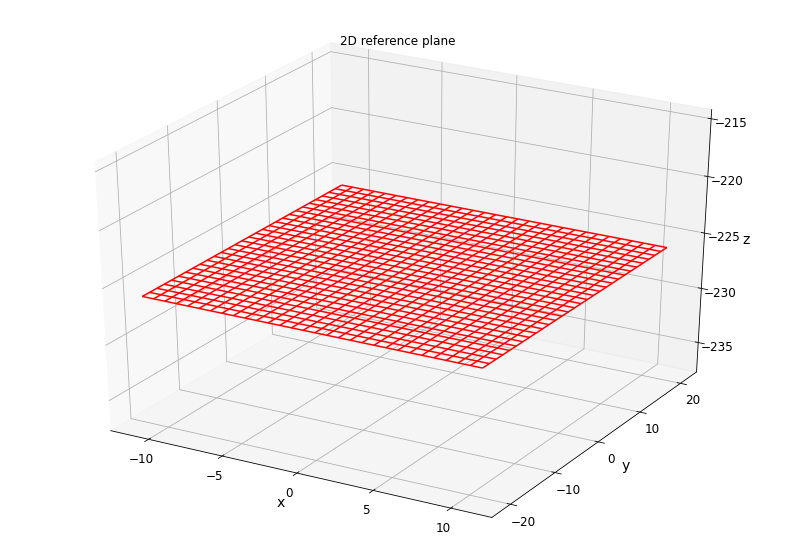

In [6]:
# Plot for a three-dimensional Plane
def z_function(x, y):
    # ax+by+cz = d ---> z = -(ax+by-d)/c
    return z_mean + 0 * x + 0 * y       


x_plane = np.linspace(-11, 11, 30)
y_plane = np.linspace(-21, 21, 30)

X, Y = np.meshgrid(x_plane, y_plane)
Z = z_function(X, Y)

plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_wireframe(X, Y, Z, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('2D reference plane')

# fig = plt.figure()
# ax = plt.axes(projection="3d")
# def z_function(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))

# x = np.linspace(-6, 6, 30)
# y = np.linspace(-6, 6, 30)

# X, Y = np.meshgrid(x, y)
# Z = z_function(X, Y)

# fig = plt.figure()
# ax = plt.axes(projection="3d")
# ax.plot_wireframe(X, Y, Z, color='green')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.show()

# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                 cmap='winter', edgecolor='none')
# ax.set_title('surface');

Text(0.5, 0.92, 'Point cloud with reference plane')

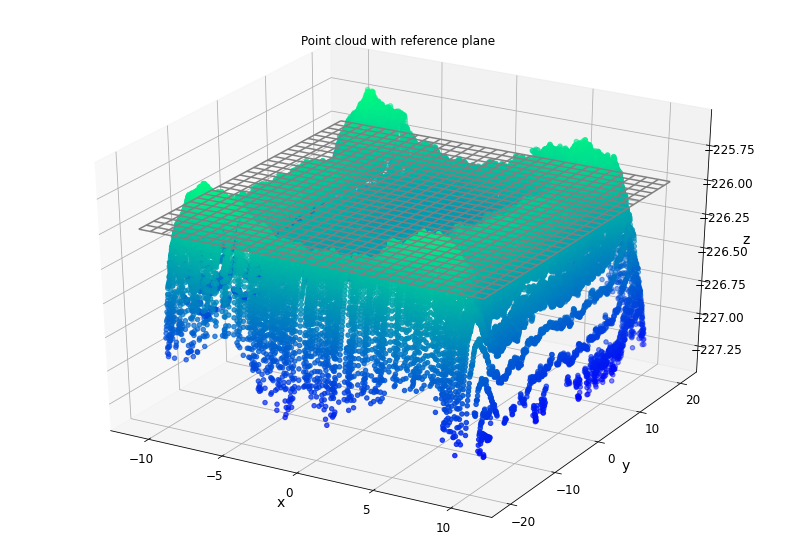

In [7]:
# this will make the plot interactive
# %matplotlib auto

plt.figure(figsize=(14, 10))
# plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

ax.plot_wireframe(X, Y, Z, color='gray')
# Data for three-dimensional scattered points, extracted from numpy array
ax.scatter3D(x, y, z, c=z, cmap='winter'); # other cmap options: winter, Greens
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('Point cloud with reference plane')

### 1.4 Point cloud visualizaiton using plotpy

In [8]:
# # For plotting
# import plotly.io as pio
# import plotly.graph_objects as go
# import chart_studio.plotly as py

# points_np_array_downsampled = np.asarray(downsample_pcd.points)
# print("the points are: \n")
# print(points_np_array)
# #------extract x value of the points-----
# x_down = points_np_array_downsampled[:,0]
# y_down = points_np_array_downsampled[:,1]
# z_down = points_np_array_downsampled[:,2]



# layout = go.Layout(
#     title='Parametric Plot',
#     scene=dict(
#         xaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)'
#         ),
#         yaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)'
#         ),
#         zaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)'
#         )
#     )
# )


# fig = go.Figure(data=[go.Scatter3d(x=x_down, y=y_down, z=z_down,
#                                    mode='markers')], layout=layout)

# py.iplot(fig, filename='jupyter-parametric_plot')
# fig.show()

## Segmentation: Remove the point below the plane

In [9]:
points_segmented = points_np_array[np.where(points_np_array[:,2] > z_mean)]

print("the point cloud segmented: ")
print(points_segmented)

the point cloud segmented: 
[[  -9.56302014  -17.74887974 -225.9817953 ]
 [  -9.56279359  -17.67781856 -225.9829139 ]
 [  -9.5634848   -17.60777515 -225.9829742 ]
 ...
 [   8.66727035   17.74265523 -225.9529622 ]
 [   8.66658094   17.81269927 -225.9530025 ]
 [   8.66716664   17.88435272 -225.9691718 ]]


Text(0.5, 0.92, 'point cloud segmented')

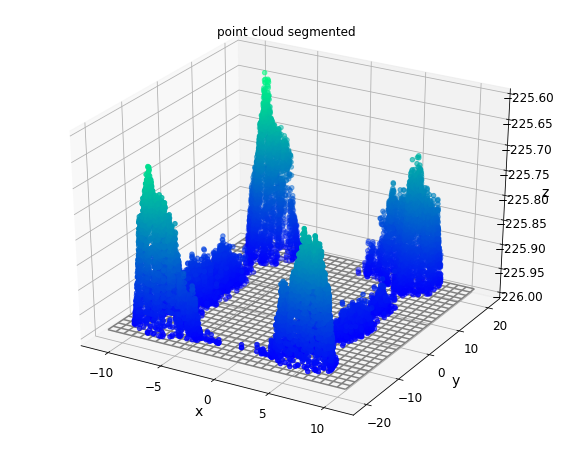

In [10]:
x_seg = points_segmented[:,0]
y_seg = points_segmented[:,1]
z_seg = points_segmented[:,2]



plt.figure(figsize=(10, 8))
# plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, Z, color='gray')
# Data for three-dimensional scattered points, extracted from numpy array
ax.scatter3D(x_seg, y_seg, z_seg, c=z_seg, cmap='winter'); # other cmap options: winter, Greens
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('point cloud segmented')

## Extract the 2D projected points from the segmented cloud

the point cloud projected on the 2D plane: 
[[  -9.56302014  -17.74887974 -225.98640157]
 [  -9.56279359  -17.67781856 -225.98640157]
 [  -9.5634848   -17.60777515 -225.98640157]
 ...
 [   8.66727035   17.74265523 -225.98640157]
 [   8.66658094   17.81269927 -225.98640157]
 [   8.66716664   17.88435272 -225.98640157]]
point_extracted shape: (17510, 3)


Text(0.5, 0.92, '2D point cloud extracted')

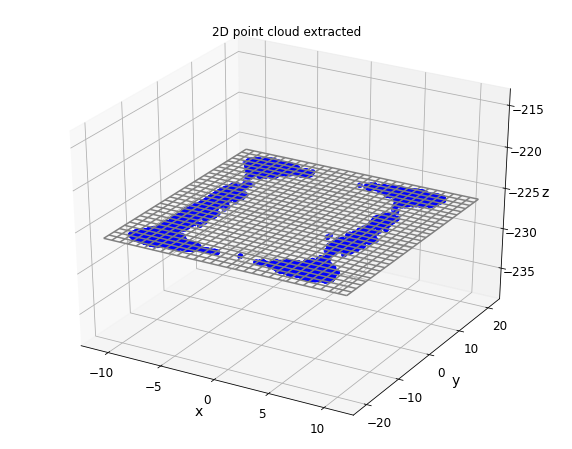

In [11]:
## set the z = z_mean for all the points
point_extracted = points_segmented
point_extracted[:,2] = z_mean
print("the point cloud projected on the 2D plane: ")
print(point_extracted)
print ("point_extracted shape: " + str(point_extracted.shape))


x_2d = point_extracted[:,0]
y_2d = point_extracted[:,1]
z_2d = point_extracted[:,2]



plt.figure(figsize=(10, 8))
# plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, Z, color='gray')
# Data for three-dimensional scattered points, extracted from numpy array
ax.scatter3D(x_2d, y_2d, z_2d, c=z_2d, cmap='winter'); # other cmap options: winter, Greens

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('2D point cloud extracted')

## Convert all points into 2D points

In [12]:
print ("point_extracted number of points: " + str(point_extracted.shape[0]))
point_2D_extracted = np.zeros((point_extracted.shape[0], 2))
point_2D_extracted[:, 0] = point_extracted[:, 0]
point_2D_extracted[:, 1] = point_extracted[:, 1]
print ("point_2D_extracted dimensin: " + str(point_2D_extracted.shape))

point_extracted number of points: 17510
point_2D_extracted dimensin: (17510, 2)


## DBSCAN clustering by Open3D

In [13]:
## produce 2D point cloud with the above numpy array data

# an open3d point cloud object
pcd_2D = o3d.geometry.PointCloud()
pcd_2D.points = o3d.utility.Vector3dVector(point_extracted)


# with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
labels = np.array(pcd_2D.cluster_dbscan(eps=0.8, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_2D.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd_2D])

point cloud has 5 clusters


## check points in each clusters

In [14]:
print("the clustered point cloud label are: \n")
print(labels)
print("size of the point cloud 2D extracted: " + str(point_2D_extracted.size))
print("size of the lables: " + str(labels.size))
17510 * 2

the clustered point cloud label are: 

[0 0 0 ... 2 2 2]
size of the point cloud 2D extracted: 35020
size of the lables: 17510


35020

## Downsample the points using voxel grid filter

In [15]:
print("Downsample the 2D point cloud with a voxel of 0.8")
downsample_pcd_2D = pcd_2D.voxel_down_sample(voxel_size=0.5)

o3d.visualization.draw_geometries([downsample_pcd_2D])

Downsample the 2D point cloud with a voxel of 0.8


#### Convert the open3D points to numpy array for further processing

In [16]:
# convert Open3D.o3d.geometry.PointCloud to numpy array
extracted_2D_downsampled = np.asarray(downsample_pcd_2D.points)
# print (extracted_2D_downsampled)

## Using Sklearn DBSCAN clustering

Estimated number of clusters: 5
Estimated number of noise points: 16


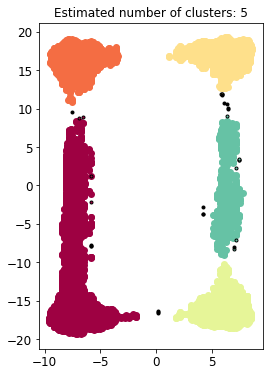

In [17]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.8, min_samples=10).fit(point_2D_extracted)
# db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt



plt.figure(figsize=(4, 6))



# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

# colors = ['r','g','b','c','y']



point_clusters = []
cluster = 0 
while cluster < n_clusters_:
    
    class_member_mask = (labels == cluster)
    point_clusters.append(point_2D_extracted[class_member_mask & core_samples_mask])
#     point_clusters.append(extracted_2D_downsampled[class_member_mask & core_samples_mask])
    cluster = cluster + 1
    
    
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
#     point_clusters[k] =  point_2D_extracted[class_member_mask & core_samples_mask]
   
    xy = point_2D_extracted[class_member_mask & core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='None', markersize=14)

    # these are the points does not belong to either clusters (noise)
    xy = point_2D_extracted[class_member_mask & ~core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [18]:
print("the dimension of the point cloud cluster: " + str(point_clusters[4].shape))

the dimension of the point cloud cluster: (1432, 2)


## Visualize one indivudual point cluster

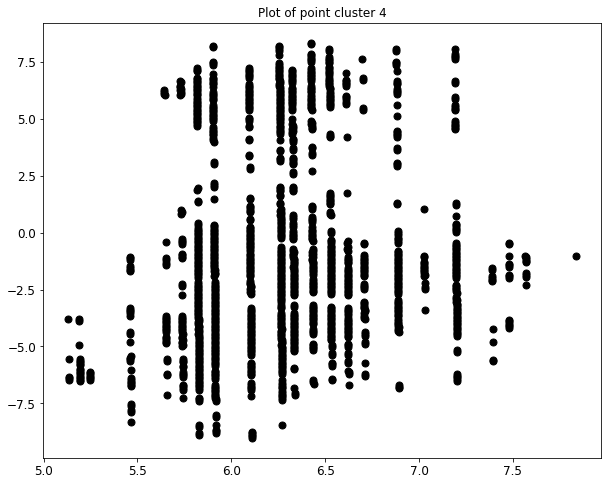

In [19]:
##---- visualize only the point cluster 5
plt.figure(figsize=(10, 8))


plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], '.', markerfacecolor=tuple(col),
        markeredgecolor='k', markersize=14)

plt.title('Plot of point cluster 4')
plt.show()

## Get the contour of each point cloud clusters

In [20]:
# tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
# # for alpha in np.logspace(np.log10(0.5), np.log10(0.01), num=2):
# for alpha in 0.5,0.4,0.3:
#     print(f"alpha={alpha:.3f}")
#     mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
#         pcd, alpha, tetra_mesh, pt_map)
#     mesh.compute_vertex_normals()
#     o3d.visualization.draw_geometries([mesh])

### Example: using open3d for concave hull fitting

In [21]:
## mesh = o3dtut.get_bunny_mesh()

# o3d.visualization.draw_geometries([pcd])
# alpha = 0.03
# print(f"alpha={alpha:.3f}")
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
#     pcd, alpha)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])

### Example : using alphashape python library to extract contour

<Figure size 720x576 with 0 Axes>

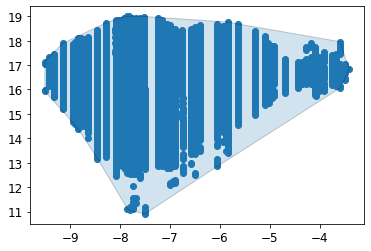

In [22]:
import alphashape
import sys
from descartes import PolygonPatch

#-------------1. using self-optimization of alpha value--------------------------
# alpha = 0.95 * alphashape.optimizealpha(point_clusters[4])
# hull = alphashape.alphashape(point_clusters[4], alpha)
# hull_pts = hull.exterior.coords.xy

# fig, ax = plt.subplots()
# ax.scatter(hull_pts[0], hull_pts[1], color='red') 


#-------------2. using user-defined alpha value--------------------------
alpha_shape = alphashape.alphashape(point_clusters[1], 0.1)
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
ax.scatter(*zip(*point_clusters[1]))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.show()



### Example : (from online)
https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation

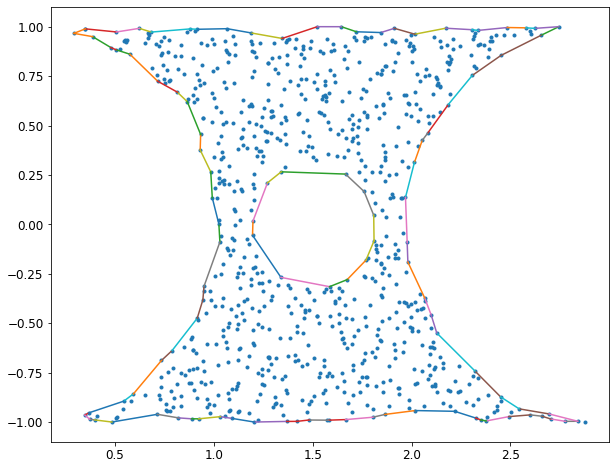

In [23]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle 外接圆
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges


# from matplotlib.pyplot import *

# Constructing the input point data
np.random.seed(0)
x = 3.0 * np.random.rand(2000)
y = 2.0 * np.random.rand(2000) - 1.0
inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0) & ((x - 1.5) ** 2 + y ** 2 > 0.09))
points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.25, only_outer=True)

# Plotting the output
plt.figure(figsize=(10, 8))
plt.axis('equal')
plt.plot(points[:, 0], points[:, 1], '.')
for i, j in edges:
    plt.plot(points[[i, j], 0], points[[i, j], 1])
plt.show()

{(294, 692), (473, 366), (578, 731), (276, 821), (606, 70), (628, 643), (723, 555), (245, 750), (29, 294), (32, 564), (167, 298), (223, 271), (610, 363), (787, 13), (483, 336), (409, 723), (658, 80), (630, 183), (829, 766), (26, 743), (280, 462), (599, 744), (564, 182), (477, 141), (801, 317), (205, 672), (69, 109), (392, 539), (70, 801), (253, 167), (664, 735), (182, 628), (632, 538), (522, 537), (382, 813), (363, 69), (514, 247), (487, 280), (711, 786), (821, 545), (744, 267), (545, 589), (328, 392), (366, 770), (643, 514), (538, 658), (39, 1), (109, 26), (634, 483), (114, 829), (289, 477), (183, 664), (267, 630), (98, 581), (813, 634), (712, 253), (743, 98), (157, 134), (317, 626), (553, 223), (731, 242), (652, 718), (542, 733), (838, 273), (134, 276), (273, 29), (718, 39), (1, 487), (766, 245), (537, 787), (80, 726), (581, 704), (13, 551), (626, 205), (681, 636), (750, 578), (741, 632), (735, 263), (733, 681), (726, 32), (672, 838), (154, 165), (165, 599), (573, 157), (247, 409), (

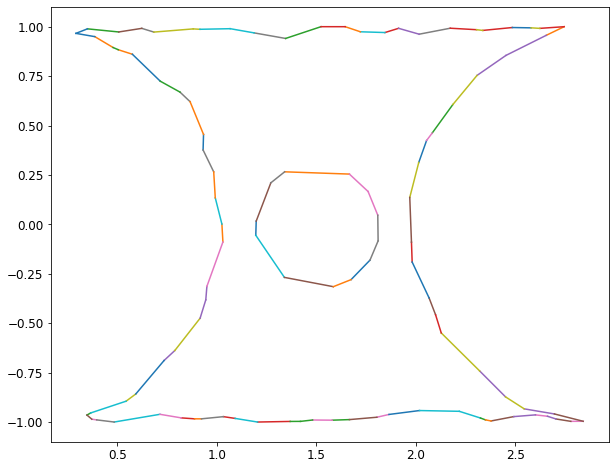

In [24]:
print (edges)
# Plotting the output
plt.figure(figsize=(10, 8))

for i, j in edges:
    plt.plot(points[[i, j], 0], points[[i, j], 1])
plt.show()

### Tuning the parameter for concave hull fitting: alpha
- current value of alpha for fitting: 5 (default)
- for point cloud cluster 1

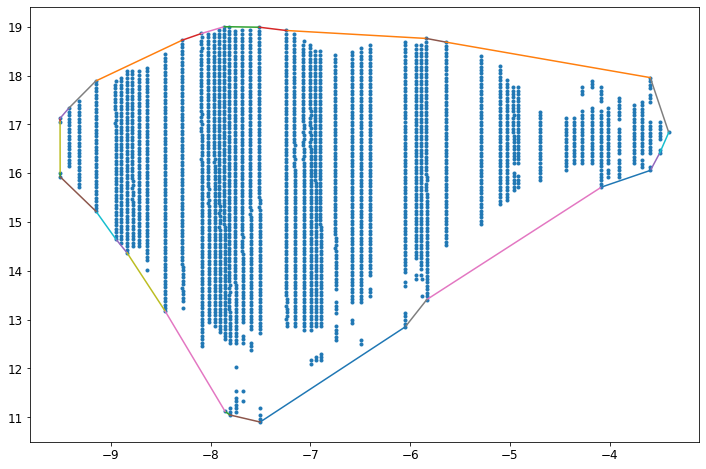

[array([-9.5099091 , -7.24462729]), array([-9.5099091 , -7.80828165]), array([-9.5099091 , -9.51050752]), array([-9.5099091 , -8.83804074]), array([-9.5099091, -5.8371427]), array([-9.5099091, -4.0807922]), array([-9.5099091 , -5.83194513]), array([-9.5099091 , -9.50976375]), array([-9.5099091 , -8.95130951]), array([-9.5099091 , -6.04854025]), array([-9.5099091 , -9.15158739]), array([-9.5099091, -9.5099091]), array([-9.5099091 , -8.28731867]), array([-9.5099091 , -3.49760769]), array([-9.5099091 , -7.50422509]), array([-9.5099091 , -8.09237637]), array([-9.5099091 , -3.59152755]), array([-9.5099091 , -8.45456718]), array([-9.5099091 , -3.40618803]), array([-9.5099091 , -3.58968265]), array([-9.5099091 , -5.64080576]), array([-9.5099091 , -7.86364789]), array([-9.5099091 , -7.51229332]), array([-9.5099091 , -9.51115761]), array([-9.5099091 , -9.14944738]), array([-9.5099091 , -7.85609261]), array([-9.5099091 , -9.42201341])]


[array([-9.50976375, -9.51050752])]


In [25]:
# Constructing the input point data

# points = np.vstack([point_clusters[4][:, 0], point_clusters[4][:, 1].T

# Computing the alpha shape
edges1 = alpha_shape(point_clusters[1], alpha=5, only_outer=True)


vertices_x_cluster_1 = []
vertices_y_cluster_1 = []
vertices_cluster_edge_test = []

# Plotting the output
plt.figure(figsize=(12, 8))
# plt.axis('equal')
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], '.')
for i, j in edges1:
    plt.plot(point_clusters[1][[i, j], 0], point_clusters[1][[i, j], 1])
     
    vertices_x_cluster_1.append(point_clusters[1][[0,j], 0]) # x coordinates of polgon vertices, vector (array)
    vertices_y_cluster_1.append( point_clusters[1][[1, j], 1])  # y coordinates of polgon vertices, vector


vertices_cluster_edge_test.append (point_clusters[1][[1, 2], 0]) 
plt.show()

print (vertices_x_cluster_1)
print ("\n")
print (vertices_cluster_edge_test)

In [26]:
# print("Show the dimension of the edges: " + edges.shape)
print("print the value of edges: " + str(edges1))

print the value of edges: {(2567, 1555), (905, 998), (3, 2), (87, 183), (2627, 2567), (2491, 2901), (2282, 2491), (2, 1), (48, 87), (1375, 2282), (552, 86), (1, 0), (644, 552), (3007, 3026), (998, 1375), (997, 644), (3034, 3025), (183, 399), (3026, 3034), (2901, 3007), (3025, 2627), (1468, 997), (1555, 1468), (21, 3), (0, 48), (399, 905), (86, 21)}


### for point cloud cluster 2 (visualization with polygon fitting)

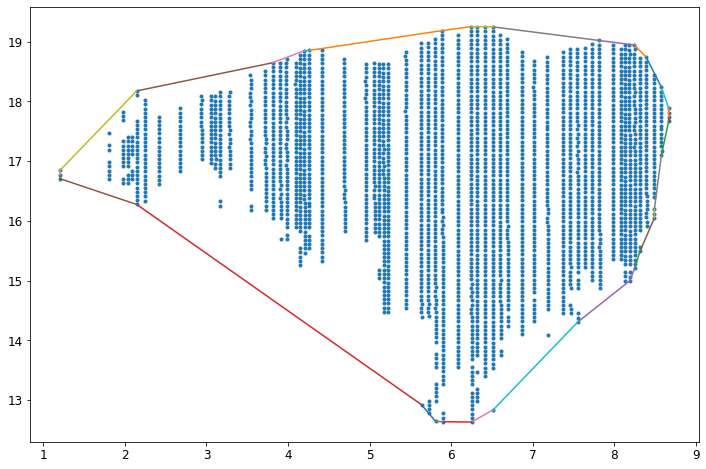

[array([-9.5099091 , -7.24462729]), array([-9.5099091 , -7.80828165]), array([-9.5099091 , -9.51050752]), array([-9.5099091 , -8.83804074]), array([-9.5099091, -5.8371427]), array([-9.5099091, -4.0807922]), array([-9.5099091 , -5.83194513]), array([-9.5099091 , -9.50976375]), array([-9.5099091 , -8.95130951]), array([-9.5099091 , -6.04854025]), array([-9.5099091 , -9.15158739]), array([-9.5099091, -9.5099091]), array([-9.5099091 , -8.28731867]), array([-9.5099091 , -3.49760769]), array([-9.5099091 , -7.50422509]), array([-9.5099091 , -8.09237637]), array([-9.5099091 , -3.59152755]), array([-9.5099091 , -8.45456718]), array([-9.5099091 , -3.40618803]), array([-9.5099091 , -3.58968265]), array([-9.5099091 , -5.64080576]), array([-9.5099091 , -7.86364789]), array([-9.5099091 , -7.51229332]), array([-9.5099091 , -9.51115761]), array([-9.5099091 , -9.14944738]), array([-9.5099091 , -7.85609261]), array([-9.5099091 , -9.42201341])]


[array([-9.50976375, -9.51050752])]


In [27]:
# Computing the alpha shape
edges2 = alpha_shape(point_clusters[2], alpha=5, only_outer=True)


vertices_x_cluster_2 = []
vertices_y_cluster_2 = []
vertices_cluster_edge_test = []

# Plotting the output
plt.figure(figsize=(12, 8))
# plt.axis('equal')
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], '.')
for i, j in edges2:
    plt.plot(point_clusters[2][[i, j], 0], point_clusters[2][[i, j], 1])
     
    vertices_x_cluster_2.append(point_clusters[2][[0,j], 0]) # x coordinates of polgon vertices, vector (array)
    vertices_y_cluster_2.append( point_clusters[2][[1, j], 1])  # y coordinates of polgon vertices, vector


vertices_cluster_edge_test.append (point_clusters[1][[1, 2], 0]) 
plt.show()

print (vertices_x_cluster_1)
print ("\n")
print (vertices_cluster_edge_test)

## Plot the point cloud clusters and the bounding box (reference plane)

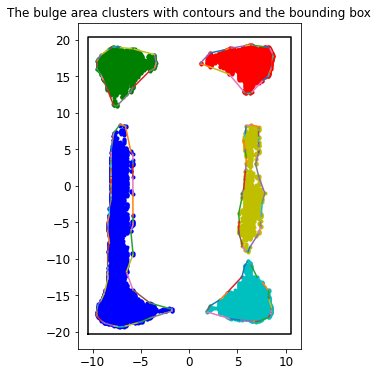

In [28]:
# Computing the alpha shape
edges0 = alpha_shape(point_clusters[0], alpha=4, only_outer=True)
edges2 = alpha_shape(point_clusters[2], alpha=4, only_outer=True)
edges3 = alpha_shape(point_clusters[3], alpha=4, only_outer=True)
edges4 = alpha_shape(point_clusters[4], alpha=4, only_outer=True)

# Plotting the output
plt.figure(figsize=(4, 6))
# plt.axis('equal')
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], 'b.')
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], 'g.')
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], 'r.')
plt.plot(point_clusters[3][:, 0], point_clusters[3][:, 1], 'c.')
plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], 'y.')
for i, j in edges0:
    plt.plot(point_clusters[0][[i, j], 0], point_clusters[0][[i, j], 1])
for i, j in edges1:
    plt.plot(point_clusters[1][[i, j], 0], point_clusters[1][[i, j], 1])
for i, j in edges2:
    plt.plot(point_clusters[2][[i, j], 0], point_clusters[2][[i, j], 1])
for i, j in edges3:
    plt.plot(point_clusters[3][[i, j], 0], point_clusters[3][[i, j], 1])
for i, j in edges4:
    plt.plot(point_clusters[4][[i, j], 0], point_clusters[4][[i, j], 1])
    
# Outer boundary
xd=[-10.5, 10.5, 10.5,-10.5,-10.5];
yd=[-20.3,-20.3, 20.3, 20.3,-20.3];

plt.plot(xd,yd,'k');
plt.title("The bulge area clusters with contours and the bounding box")

plt.show()

## Another method for Concave hull (polygon fitting) 
---- This one will be chosen

### 1. ConcaveHull.py from https://gist.github.com/AndreLester/589ea1eddd3a28d00f3d7e47bd9f28fb
http://www.rotefabrik.free.fr/concave_hull/

Advantage: fast, directly give the boundaries of edges with points in numpy array format

In [29]:
'''
Copyright (C) 2018  Andre Lester Kruger

ConcaveHull.py is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 2 of the License, or
(at your option) any later version.

ConcaveHull.py is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with ConcaveHull.py.  If not, see <http://www.gnu.org/licenses/>.
'''

import bisect
from collections import OrderedDict
import math
#import numpy as np
import matplotlib.tri as tri
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.ops import linemerge


class ConcaveHull:
    
    def __init__(self):
        self.triangles = {}
        self.crs = {}
        
    
    def loadpoints(self, points):
        #self.points = np.array(points)
        self.points = points
        
        
    def edge(self, key, triangle):
        '''Calculate the length of the triangle's outside edge
        and returns the [length, key]'''
        pos = triangle[1].index(-1)
        if pos==0:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][1]]
        elif pos==1:
            x1, y1 = self.points[triangle[0][1]]
            x2, y2 = self.points[triangle[0][2]]
        elif pos==2:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][2]]
        length = ((x1-x2)**2+(y1-y2)**2)**0.5
        rec = [length, key]
        return rec
        
    
    def triangulate(self):
        
        if len(self.points) < 2:
            raise Exception('CountError: You need at least 3 points to Triangulate')
        
        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del(temp)
        
        triang = tri.Triangulation(x, y)
        
        self.triangles = {}
        
        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
        

    def calculatehull(self, tol=50):
        
        self.tol = tol
        
        if len(self.triangles) == 0:
            self.triangulate()
        
        # All triangles with one boundary longer than the tolerance (self.tol)
        # is added to a sorted deletion list.
        # The list is kept sorted from according to the boundary edge's length
        # using bisect        
        deletion = []    
        self.boundary_vertices = set()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])
            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self.edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
        while len(deletion) != 0:
            # The triangles with the longest boundary edges will be 
            # deleted first
            item = deletion.pop()
            ref = item[1]
            flag = 0
            
            # Triangle will not be deleted if it already has two boundary edges            
            if self.triangles[ref][1].count(-1) > 1:
                continue
                
            # Triangle will not be deleted if the inside node which is not
            # on this triangle's boundary is already on the boundary of 
            # another triangle
            adjust = {0: 2, 1: 0, 2: 1}            
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue
           
            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self.edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)
                                        
            del self.triangles[ref]
            
        self.polygon()
            
                    

    def polygon(self):
        
        edgelines = []
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos==0:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][1]]
                        elif pos==1:
                            x1, y1 = self.points[triangle[0][1]]
                            x2, y2 = self.points[triangle[0][2]]
                        elif pos==2:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][2]]
                        line = LineString([(x1, y1), (x2, y2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)
    
        self.boundary = Polygon(bound.coords)
        
        
        
#if __name__ == '__main__':

### visualization (cluster 0)

- Hyperparameter for tuning: tol (equivalent to alpha value)

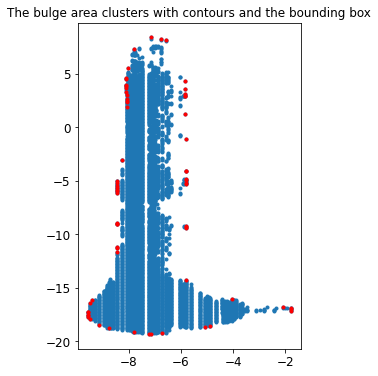

[[ -9.5634848  -17.60777515]
 [ -9.56302014 -17.74887974]
 [ -9.47851699 -17.95959273]
 [ -9.11761151 -18.46083308]
 [ -8.75113822 -18.81763292]
 [ -7.77992328 -19.19316765]
 [ -7.20933058 -19.33870567]
 [ -7.12406684 -19.34029991]
 [ -6.71589772 -19.27917588]
 [ -5.06245858 -18.66787476]
 [ -4.88287537 -18.5976883 ]
 [ -1.79843862 -17.15817805]
 [ -1.79878351 -17.01800267]
 [ -1.799247   -16.87584928]
 [ -2.08671842 -16.79918684]
 [ -4.05136342 -16.0624997 ]
 [ -5.80649212 -14.28080698]
 [ -5.81072562  -9.42281761]
 [ -5.81097803  -9.35038047]
 [ -5.81098954  -9.28051593]
 [ -5.81490425  -5.34086754]
 [ -5.81453252  -5.20086149]
 [ -5.81524029  -4.98866294]
 [ -5.81518631  -4.84785563]
 [ -5.8162692   -4.14618928]
 [ -5.81552418  -4.07646385]
 [ -5.81907176  -1.12638768]
 [ -5.8212472    1.25960566]
 [ -5.82288625   2.87364236]
 [ -5.82280902   2.94393488]
 [ -5.82275968   3.08402917]
 [ -5.82332879   3.57611922]
 [ -5.82416619   4.2779746 ]
 [ -6.57583444   8.15191707]
 [ -6.74090133

In [30]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[0]
ch.loadpoints(pts)
ch.calculatehull(tol = 5)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(4, 6))
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], '.')
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.')


plt.title("The bulge area cluster 0 with its countour in red points (polygon edges)")

plt.show()

print (boundary_points)
print (boundary_points.shape)

### plot the whole picture edges (polygon boundary) with point cloud clusters and bounding box

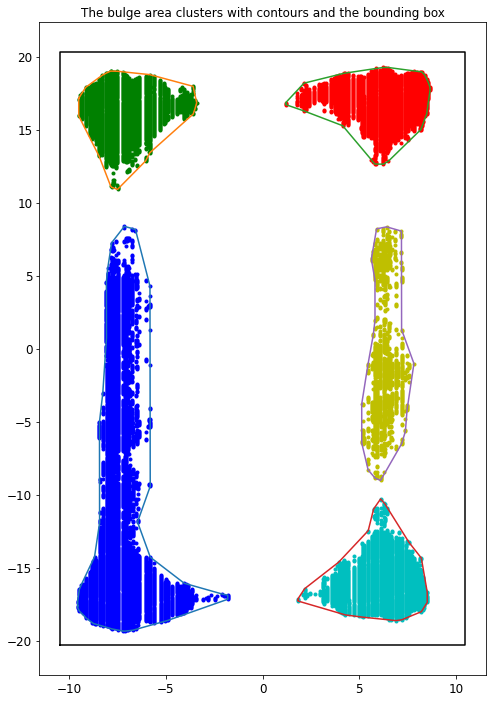

In [31]:
# from ConcaveHull import ConcaveHull

ch0 = ConcaveHull()
ch1 = ConcaveHull()
ch2 = ConcaveHull()
ch3 = ConcaveHull()
ch4 = ConcaveHull()

pts0 = point_clusters[0]
pts1 = point_clusters[1]
pts2 = point_clusters[2]
pts3 = point_clusters[3]
pts4 = point_clusters[4]

ch0.loadpoints(pts0)
ch1.loadpoints(pts1)
ch2.loadpoints(pts2)
ch3.loadpoints(pts3)
ch4.loadpoints(pts4)

ch0.calculatehull(tol = 4)     ## a hyperparameter for tuning
ch1.calculatehull(tol = 4)
ch2.calculatehull(tol = 4)
ch3.calculatehull(tol = 4)
ch4.calculatehull(tol = 4)

boundary_points0 = np.vstack(ch0.boundary.exterior.coords.xy).T
boundary_points1 = np.vstack(ch1.boundary.exterior.coords.xy).T
boundary_points2 = np.vstack(ch2.boundary.exterior.coords.xy).T
boundary_points3 = np.vstack(ch3.boundary.exterior.coords.xy).T
boundary_points4 = np.vstack(ch4.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull

# Plotting the output
plt.figure(figsize=(8, 12))
# plt.axis('equal')
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], 'b.')
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], 'g.')
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], 'r.')
plt.plot(point_clusters[3][:, 0], point_clusters[3][:, 1], 'c.')
plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], 'y.')

plt.plot(boundary_points0[:, 0], boundary_points0[:, 1])
plt.plot(boundary_points1[:, 0], boundary_points1[:, 1])
plt.plot(boundary_points2[:, 0], boundary_points2[:, 1])
plt.plot(boundary_points3[:, 0], boundary_points3[:, 1])
plt.plot(boundary_points4[:, 0], boundary_points4[:, 1])

# Outer boundary
xd=[-10.5, 10.5, 10.5,-10.5,-10.5]
yd=[-20.3,-20.3, 20.3, 20.3,-20.3]

plt.plot(xd,yd,'k');
plt.title("The bulge area clusters with contours and the bounding box")

plt.show()

# Tool path generation

## polyline.py from OpenLMD

## mlabplot.py from OpenLMD

## Contours.py from OpenLMD

# Polygon infill path generate

https://stackoverflow.com/questions/61853250/polygon-infill-path-generate

https://stackoverflow.com/questions/15668149/polygon-infill-algorithm

https://github.com/Tannz0rz/Mandoline

https://www.mathworks.com/matlabcentral/answers/158900-plotting-zigzag-in-a-2d-contour

https://github.com/nahyunkwon/gcode-modification/blob/87e896818704765201d1f3bcf8604f44d23338fa/adhesion_structure.py

# 1. Python inpolygon function
- Need to find a suitable function performing "inpolygon" equivalent as matlab
- Matlab inpolygons function:  
   - It allows the input polygon vertices to describe multiple NaN-delimited polygons. 
   - The polygons can also include holes.  
   - returns true/ false to tell if the points are lie in the polygon

## 1.1 Method one - matplotlib import path
https://stackoverflow.com/questions/31542843/inpolygon-for-python-examples-of-matplotlib-path-path-contains-points-method

In [32]:
from matplotlib import path
p = path.Path([(0,0), (0, 1), (1, 1), (1, 0)])  # square with legs length 1 and bottom left corner at the origin (CW)
p.contains_points([(.5, .5)])

array([ True])

In [33]:
# use a numpy array of points as well:
points = np.array([.5, .5]).reshape(1, 2)
# >>> points
# array([[ 0.5,  0.5]])
p.contains_points(points)

array([ True])

#### Example

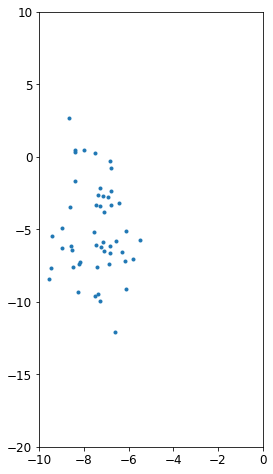

In [46]:
## generate some random points
# np.random.seed(1)
xy_points_random = np.random.randn(50,2) ; # dimension 250 x 2
xy_points_random[:,0] = xy_points_random[:,0] - 7.5
xy_points_random[:,1] = xy_points_random[:,1] * 3 - 5

plt.figure(figsize=(4, 8))
plt.plot(xy_points_random[:, 0], xy_points_random[:, 1], '.')
plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.show()

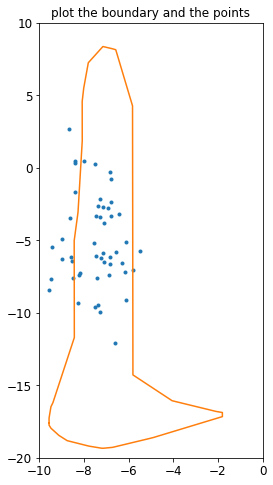

In [47]:
# create a polygon path with 'boundary_points' generated before (one of the hole)
p = path.Path(boundary_points)

plt.figure(figsize=(4, 8))

plt.plot(xy_points_random[:, 0], xy_points_random[:, 1], '.')
plt.plot(boundary_points[:, 0], boundary_points[:, 1])
plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.title("plot the boundary and the points")
plt.show()

In [88]:
## Determine whether each point lies inside or on the edge of the polygon area.
# point_in = []
point_in = p.contains_points(xy_points_random)
print (point_in)
print (point_in.shape)

[ True  True  True  True  True  True  True False False False False  True
  True False  True  True False  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True False]
(50,)


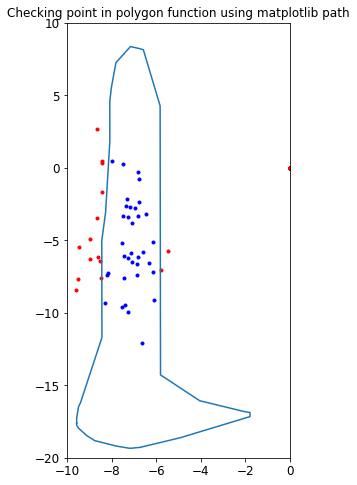

In [50]:
## visualize the graph
# Plotting the output
plt.figure(figsize=(4, 8))

plt.plot(xy_points_random[:, 0]*point_in, xy_points_random[:, 1]*point_in, 'b.')
plt.plot(xy_points_random[:, 0]*(~point_in), xy_points_random[:, 1]*(~point_in), 'r.')

plt.plot(boundary_points[:, 0], boundary_points[:, 1])

plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.title("Checking point in polygon function using matplotlib path")
plt.show()

## Convert this method to the matlab inpolygon equivalent
###  __Disadvantage__:  
- cannot return if the point is on the edge of the polygon
- difficult to use if polygon contains holes


In [51]:
def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

In [52]:
xv = np.array([0.5,0.2,1.0,0,0.8,0.5])
yv = np.array([1.0,0.1,0.7,0.7,0.1,1])
xq = np.array([0.1,0.5,0.9,0.2,0.4,0.5,0.5,0.9,0.6,0.8,0.7,0.2])
yq = np.array([0.4,0.6,0.9,0.7,0.3,0.8,0.2,0.4,0.4,0.6,0.2,0.6])
print(inpolygon(xq, yq, xv, yv))

[False False False  True  True  True False False False  True  True  True]


## Method 2 - Shapely
https://gis.stackexchange.com/questions/170264/python-point-in-polygon-boundary-and-vertex-check-ray-casting

https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates

In [73]:
from shapely.geometry import Point, Polygon,LinearRing, MultiPoint

## create a polygon object using 'boundary_points'
polygon = Polygon(boundary_points)

In [57]:
# boundary of the polygon = LinearRing
linearring = LinearRing(list(polygon.exterior.coords))
print (linearring)

LINEARRING (-9.563484803 -17.60777515, -9.563020136 -17.74887974, -9.478516986000001 -17.95959273, -9.117611514 -18.46083308, -8.751138219 -18.81763292, -7.779923279 -19.19316765, -7.20933058 -19.33870567, -7.124066844 -19.34029991, -6.715897721 -19.27917588, -5.062458582 -18.66787476, -4.882875368 -18.5976883, -1.798438623 -17.15817805, -1.798783509 -17.01800267, -1.799246999 -16.87584928, -2.086718422 -16.79918684, -4.051363424 -16.0624997, -5.80649212 -14.28080698, -5.810725621 -9.422817607000001, -5.81097803 -9.350380465000001, -5.810989539 -9.280515926, -5.814904248 -5.340867539, -5.814532519 -5.200861489, -5.815240292 -4.988662938, -5.815186309 -4.847855625, -5.816269199 -4.146189281, -5.815524175 -4.076463852, -5.819071757 -1.126387678, -5.821247198 1.259605659, -5.822886251 2.873642357, -5.822809018 2.943934876, -5.822759678 3.084029174, -5.823328785 3.576119223, -5.824166189 4.277974596, -6.575834436 8.151917065999999, -6.740901329 8.223440951000001, -7.150630623 8.37216051300

In [65]:
# contains
print (polygon.contains(linearring))
print (polygon.touches(linearring))
# polygon.intersect(linearring)

False
True


In [67]:
# a vertex 
point = Point(-9.563484803, -17.60777515)
print (polygon.contains(point))
print (polygon.touches(point))
# polygon.intersect(point)

False
True


In [68]:
linearring.contains(point)

True

## Visualzation

In [77]:
## generate some random points
# np.random.seed(1)
xy_points_random = np.random.randn(50,2) ; # dimension 250 x 2

xy_points_random[:,0] = xy_points_random[:,0] - 7.5
xy_points_random[:,1] = xy_points_random[:,1] * 3 - 5

points = MultiPoint(xy_points_random)

print(points)

MULTIPOINT (-6.379535850140952 -8.389631688181479, -5.910077008602721 -2.063809697832489, -6.565836374883641 -7.444125782630929, -7.75124244717852 -6.148504615072634, -7.499659042066318 -5.18661440197971, -7.817348880819027 -5.533782038363878, -7.711620316961177 -4.197548410824299, -9.1518170353951 -3.540264953517527, -5.802728301617055 -1.78249745814874, -8.445897226457323 -1.866175928868926, -5.210372147400958 -5.727668778506787, -6.778968078707104 1.898141199938778, -6.469704372406308 -0.3478381963925132, -8.595225555508733 -4.293137426097303, -7.108030897361549 -3.307138612121293, -6.71049245359424 -4.531474828220008, -8.81239413601082 -1.801182756118237, -7.121139671348556 -8.53584988879958, -6.741004179172505 -3.341059962603175, -6.962965452325345 -5.860505624583681, -5.865594355080098 -3.286320106974333, -8.28995406014219 -9.628273821313037, -8.267332182791117 -12.10886987990664, -7.760559844047124 -4.613128848224016, -8.707666434722325 -6.636330772506411, -5.946717349855237 -4.

In [91]:
## Determine whether each point lies inside or on the edge of the polygon area.
## --- this will only return one value-----
point_in = polygon.contains(points)
point_on_edge = polygon.touches(points)
##---- the correct way---------
point_in_list = []
for point in points:
    point_in_list.append(polygon.contains(point))

point_in_array = np.array(point_in_list)
print (point_in_list)

[True, True, True, True, True, True, True, False, False, False, False, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False]


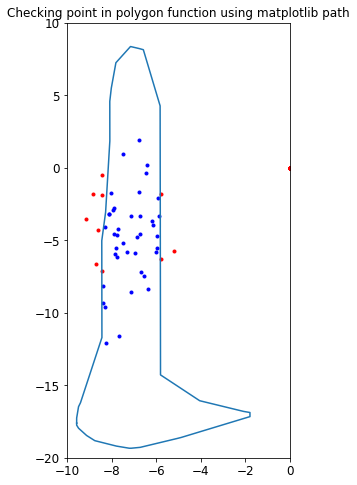

In [92]:
## visualize the graph
# Plotting the output
plt.figure(figsize=(4, 8))

plt.plot(xy_points_random[:, 0]*point_in_array, xy_points_random[:, 1]*point_in_array, 'b.')
plt.plot(xy_points_random[:, 0]*(~point_in_array), xy_points_random[:, 1]*(~point_in_array), 'r.')

plt.plot(boundary_points[:, 0], boundary_points[:, 1])

plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.title("Checking point in polygon function using matplotlib path")
plt.show()

### Summary
- Due to more robust and user-friendly functionalities, Shapely is chosen

## Polygon with hole (shapely)

- given __outer__ as a plain Polygon and __inners__ as a list of plain Polygons (each of them contained in outer) :

- Polygons

class Polygon(shell[, holes=None])
The Polygon constructor takes two positional parameters. The first is an ordered sequence of (x, y[, z]) point tuples and is treated exactly as in the LinearRing case. The second is an optional unordered sequence of ring-like sequences specifying the interior boundaries or “holes” of the feature.



## __figures.py__ -- a utility function downloaded from shapely.figures.py

https://raw.githubusercontent.com/Toblerity/Shapely/master/docs/code/figures.py

In [109]:
from math import sqrt
from shapely import affinity

GM = (sqrt(5)-1.0)/2.0
W = 8.0
H = W*GM
SIZE = (W, H)

BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

def plot_line(ax, ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)

def plot_coords(ax, ob, color=GRAY, zorder=1, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, 'o', color=color, zorder=zorder, alpha=alpha)

def color_isvalid(ob, valid=BLUE, invalid=RED):
    if ob.is_valid:
        return valid
    else:
        return invalid

def color_issimple(ob, simple=BLUE, complex=YELLOW):
    if ob.is_simple:
        return simple
    else:
        return complex

def plot_line_isvalid(ax, ob, **kwargs):
    kwargs["color"] = color_isvalid(ob)
    plot_line(ax, ob, **kwargs)

def plot_line_issimple(ax, ob, **kwargs):
    kwargs["color"] = color_issimple(ob)
    plot_line(ax, ob, **kwargs)

def plot_bounds(ax, ob, zorder=1, alpha=1):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color=BLACK, zorder=zorder, alpha=alpha)

def add_origin(ax, geom, origin):
    x, y = xy = affinity.interpret_origin(geom, origin, 2)
    ax.plot(x, y, 'o', color=GRAY, zorder=1)
    ax.annotate(str(xy), xy=xy, ha='center',
                textcoords='offset points', xytext=(0, 8))

def set_limits(ax, x0, xN, y0, yN):
    ax.set_xlim(x0, xN)
    ax.set_xticks(range(x0, xN+1))
    ax.set_ylim(y0, yN)
    ax.set_yticks(range(y0, yN+1))
    ax.set_aspect("equal")

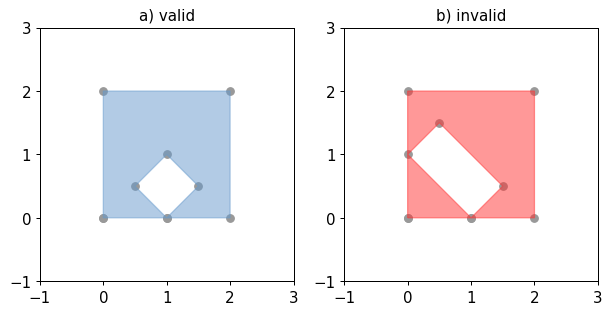

In [133]:
from matplotlib import pyplot
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch


fig = pyplot.figure(1, figsize=SIZE, dpi=90)

# 1: valid polygon
ax = fig.add_subplot(121)

ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(1, 0), (0.5, 0.5), (1, 1), (1.5, 0.5), (1, 0)][::-1]
polygon = Polygon(ext, [int])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.exterior)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('a) valid')

set_limits(ax, -1, 3, -1, 3)

#2: invalid self-touching ring
ax = fig.add_subplot(122)
ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(1, 0), (0, 1), (0.5, 1.5), (1.5, 0.5), (1, 0)][::-1]
polygon = Polygon(ext, [int])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.exterior)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('b) invalid')

set_limits(ax, -1, 3, -1, 3)

pyplot.show()


## Testing with our example -- Plot the polygon with clustered bulge area as holes

In [161]:
def plot_filled_polygons(polygons, facecolour='green', edgecolour='black', linewidth=1, alpha=0.5):
        """
        This function plots a series of shapely polygons but fills them in

        Args:
            ax_list: list of axes
            polygons: list of shapely polygons

        Author: FJC
        """
        from shapely.geometry import Polygon
        from descartes import PolygonPatch
        from matplotlib.collections import PatchCollection

        print('Plotting the polygons...')

        #patches = []
        for key, poly in polygons.items():
            this_patch = PolygonPatch(poly, fc=facecolour, ec=edgecolour, alpha=alpha)
            self.ax_list[0].add_patch(this_patch)

Text(0.5, 1.0, 'Plot Polygon with holes')

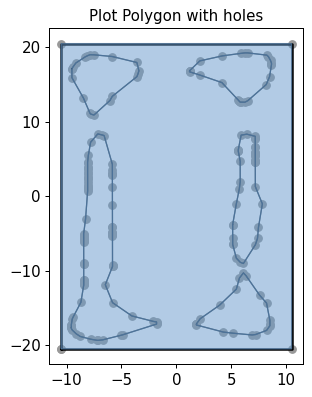

In [166]:
fig = pyplot.figure(1, figsize=SIZE, dpi=90)

# 1: valid polygon
ax = fig.add_subplot(121)

# Define exterior boundary CCW direction
ext = [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]
## Define interior boundaries
## ---- boundary_points0, boundary_points1, boundary_points２,boundary_points3, boundary_points4
polygon = Polygon(ext, [boundary_points0, boundary_points1, boundary_points2, boundary_points3, boundary_points4][::-1])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.interiors[1])
plot_coords(ax, polygon.interiors[2])
plot_coords(ax, polygon.interiors[3])
plot_coords(ax, polygon.interiors[4])
plot_coords(ax, polygon.exterior)

plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=2, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('Plot Polygon with holes')


In [164]:
## Testing the points
myPoint = Point(-7.5, -18)
print(myPoint.within(polygon))  # returns 'False'
myPoint2 = Point(0, 0)
print(myPoint2.within(polygon))  # returns 'True'
myPoint３ = Point(5, 0)
print(myPoint3.within(polygon))  # returns 'True'

False
True
True


Text(0.5, 1.0, 'Plot Polygon with holes')

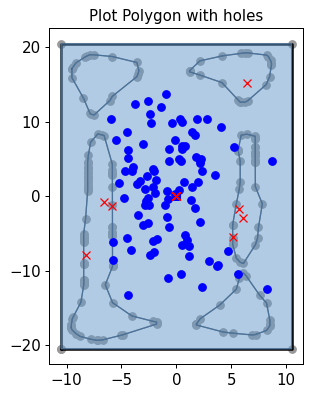

In [183]:
## generate some random points
# np.random.seed(1)
xy_points_random = np.random.randn(100,2) ; # dimension 250 x 2

xy_points_random[:,0] = xy_points_random[:,0]*4
xy_points_random[:,1] = xy_points_random[:,1]*8

points = MultiPoint(xy_points_random)


## Determine whether each point lies inside or on the edge of the polygon area.
##---- the correct way---------
point_in_list = []
for point in points:
    point_in_list.append(polygon.contains(point))

point_in_array = np.array(point_in_list)


#----visualization
fig = pyplot.figure(1, figsize=SIZE, dpi=90)

ax = fig.add_subplot(121)

# Define exterior boundary CCW direction
ext = [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]
## Define interior boundaries
## ---- boundary_points0, boundary_points1, boundary_points２,boundary_points3, boundary_points4
polygon = Polygon(ext, [boundary_points0, boundary_points1, boundary_points2, boundary_points3, boundary_points4][::-1])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.interiors[1])
plot_coords(ax, polygon.interiors[2])
plot_coords(ax, polygon.interiors[3])
plot_coords(ax, polygon.interiors[4])
plot_coords(ax, polygon.exterior)

plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=2, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)


plt.plot(xy_points_random[:, 0]*point_in_array, xy_points_random[:, 1]*point_in_array, 'bo')
plt.plot(xy_points_random[:, 0]*(~point_in_array), xy_points_random[:, 1]*(~point_in_array), 'rx')


patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('Plot Polygon with holes')


